<a href="https://colab.research.google.com/github/rianlucass/estudo-de-caso/blob/main/Estudo_de_caso_Algoritmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Montando o Google Drive no caminho /content/drive, tornando os arquivos do Drive acessíveis dentro do ambiente do Google Colab.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Definindo na variável base o caminho até a base de dados no Google Drive.

In [ ]:
base = '/content/drive/MyDrive/ads2/apq/cedulas.txt'

Importando as bibliotecas necessárias.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

Transformando a base de dados em um DataFrame.

In [ ]:
dados = pd.read_csv(base, header=None, names=['variancia', 'assimetria', 'curtose', 'entropia', 'classe'])

Exibindo as primeiras linhas da base de dados, ajudando a visualizar a estrutura e os dados iniciais.

In [ ]:
dados.head()

,variancia,assimetria,curtose,entropia,classe
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Verificando se há valores nulos na base de dados.

In [ ]:
dados.isnull().sum()

,0
variancia,0
assimetria,0
curtose,0
entropia,0
classe,0


Verificando as dimensões da base de dados.

In [ ]:
dados.shape

(1372, 5)

Verificando a quantidade de elementos de cada classe para saber se a base de dados é balanceada ou não.

In [ ]:
contagem = dados['classe'].value_counts()
print(contagem)

classe
0    762
1    610
Name: count, dtype: int64


Gráfico das classes para melhor visualização.

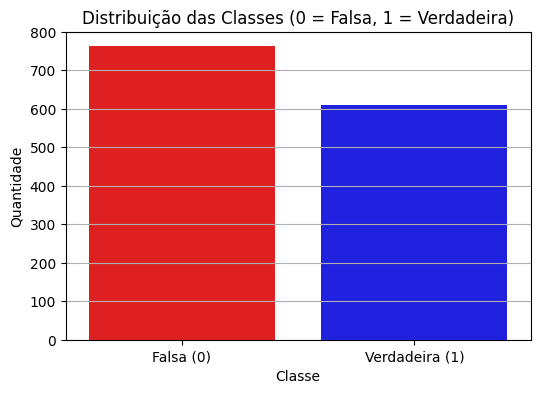

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='classe', hue='classe', data=dados, palette=['red', 'blue'], legend=False)
plt.title('Distribuição das Classes (0 = Falsa, 1 = Verdadeira)')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.xticks([0, 1], ['Falsa (0)', 'Verdadeira (1)'])
plt.grid(axis='y')
plt.show()


In [ ]:
dados.describe()

,variancia,assimetria,curtose,entropia,classe
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Verificando a presença de outliers

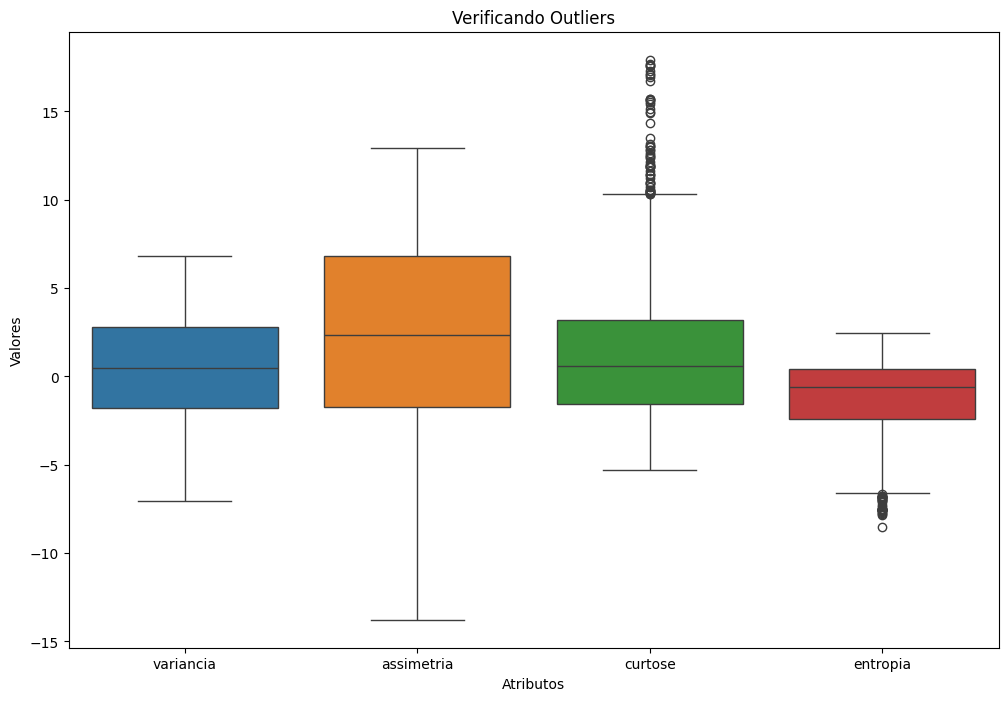

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=dados.drop('classe', axis=1))
plt.title('Verificando Outliers')
plt.xlabel('Atributos')
plt.ylabel('Valores')
plt.show()

Verificando a quantidade de outliers usando z-score por atributos.

In [ ]:
z_scores = np.abs(zscore(dados.drop('classe', axis=1)))
outliers = (z_scores > 3)

print("Outliers detectados por atributo:")
print(outliers.sum(axis=0))


Outliers detectados por atributo:
[ 0  0 20 16]


Verifiando a quantidade de outliers por classe.

In [ ]:
linhas_com_outlier = outliers.any(axis=1)
classes_outliers = dados.loc[linhas_com_outlier, 'classe']
quantidade_por_classe = classes_outliers.value_counts()

print("Quantidade de outliers por classe:")
print(quantidade_por_classe)

Quantidade de outliers por classe:
classe
1    25
0    11
Name: count, dtype: int64


Verificando a porcentagem que os outliers representam por classe para melhor decisão se é bom eliminalos ou tratalos.

In [ ]:
def calcula_percentual(parcial, total):
    return (parcial / total) * 100
print("Classe 0: Se 762 é 100%, então 11 é:")
print(f"{calcula_percentual(11, 762):.2f}%")

print("Classe 1: Se 610 é 100%, então 25 é:")
print(f"{calcula_percentual(25, 610):.2f}%")


Classe 0: Se 762 é 100%, então 11 é:
1.44%
Classe 1: Se 610 é 100%, então 25 é:
4.10%


Removendo os outliers intendificado pelo z-score

In [ ]:
remover_linhas = linhas_com_outlier
dados_filtrados = dados[~remover_linhas].reset_index(drop=True)

Verificando as dimensões da base depois da remoção do outliers.

In [ ]:
dados_filtrados.shape

(1336, 5)

Visualizando a dispersão dos dados com um gráfico 3d não interativo.

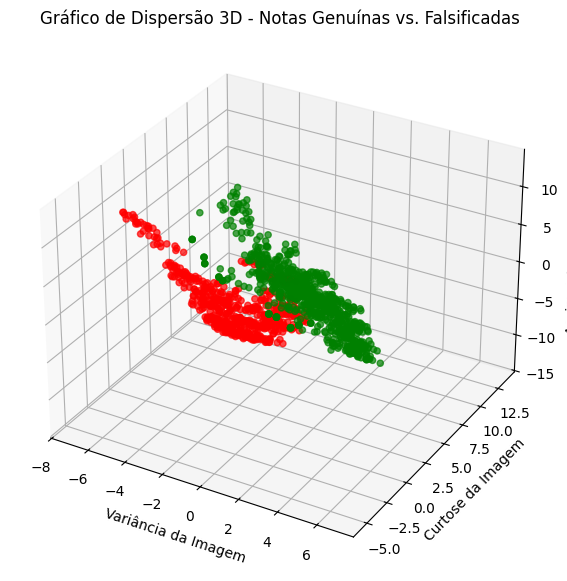

In [ ]:
df = dados_filtrados

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

x = df["variancia"]
y = df["curtose"]
z = df["assimetria"]
classe = df["classe"]

colors = ["green" if c == 0 else "red" for c in classe]

ax.scatter(x, y, z, c=colors, alpha=0.7)

ax.set_xlabel("Variância da Imagem")
ax.set_ylabel("Curtose da Imagem")
ax.set_zlabel("Assimetria da Imagem")
ax.set_title("Gráfico de Dispersão 3D - Notas Genuínas vs. Falsificadas")

plt.show()

Definindo as entradas na variável x e as saídas na variável y.

In [ ]:
X = dados_filtrados.drop('classe', axis=1)
y = dados_filtrados['classe']

Normalizando os dados da variável x

In [ ]:
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

Dividindo o conjunto de dados em dados de treinamento e dados de teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalizado, y, test_size=0.3, random_state=42)

Verificando qual o melhor valor de k para o KNN.

Melhor k: 1 com acurácia: 1.00


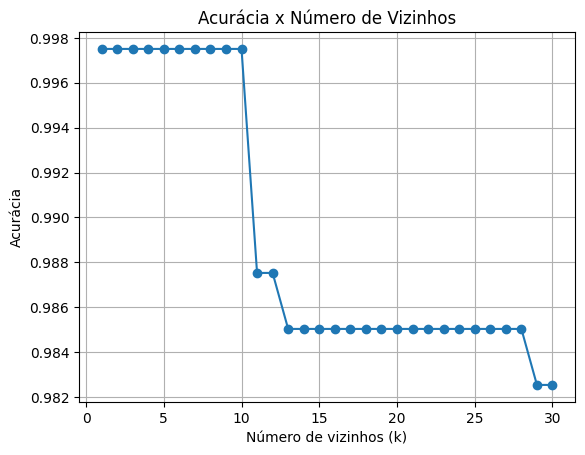

In [ ]:
k_valor = range(1, 31)
acuracias_mk = []

for k in k_valor:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_mk = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_mk)
    acuracias_mk.append(acc)

melhor_k = k_valor[acuracias_mk.index(max(acuracias_mk))]
print(f"Melhor k: {melhor_k} com acurácia: {max(acuracias_mk):.2f}")

plt.plot(k_valor, acuracias_mk, marker='o')
plt.xlabel('Número de vizinhos (k)')
plt.ylabel('Acurácia')
plt.title('Acurácia x Número de Vizinhos')
plt.grid(True)
plt.show()


Criando o classificador KNN com o valor de k sendo igual a 3, pois de valor 1 até o 10 não há alteração na acurácia, como visto no gráfico acima.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

Treinando o modelo KNN com os dados de treino.

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Prevendo as classes com os dados de testes.

In [ ]:
y_pred_knn = knn.predict(X_test)

Calculando e exibindo a acurácia do KNN

In [ ]:
acuracia_knn = accuracy_score(y_test, y_pred_knn)
print("Acurácia do KNN:", acuracia_knn)

Acurácia do KNN: 0.9975062344139651


Exibindo um relatório detalhado com métricas de desempenho do classificador KNN.

In [ ]:
print("Relatório KNN:")
print(classification_report(y_test, y_pred_knn))

Relatório KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       0.99      1.00      1.00       174

    accuracy                           1.00       401
   macro avg       1.00      1.00      1.00       401
weighted avg       1.00      1.00      1.00       401



Gerando gráfico da matriz de confusão do KNN.

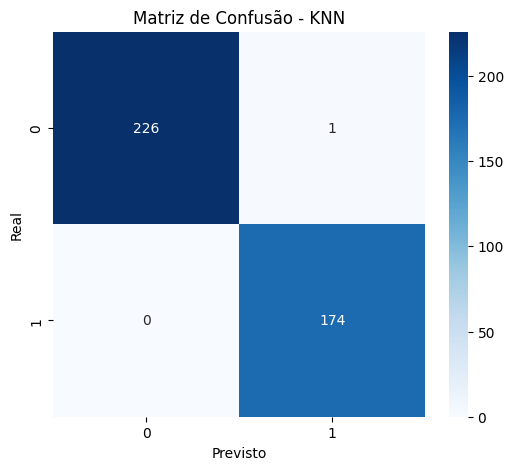

In [ ]:
mc_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(mc_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - KNN')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [ ]:
svm = SVC(kernel='linear')

In [ ]:
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
y_pred_svm = svm.predict(X_test)

In [ ]:
acuracia_svm = accuracy_score(y_test, y_pred_svm)
print("Acurácia do SVM:", acuracia_svm)

Acurácia do SVM: 0.9800498753117207


In [ ]:
print("Relatório SVM:")
print(classification_report(y_test, y_pred_svm))

Relatório SVM:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       227
           1       0.96      1.00      0.98       174

    accuracy                           0.98       401
   macro avg       0.98      0.98      0.98       401
weighted avg       0.98      0.98      0.98       401



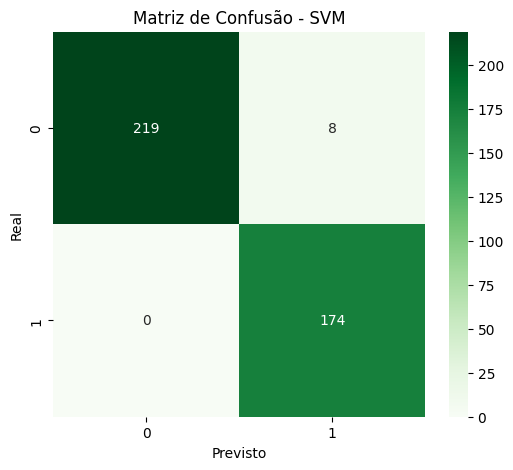

In [ ]:
mc_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(mc_svm, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - SVM')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
acuracia_rf = accuracy_score(y_test, y_pred_rf)
print("Acurácia do Random Forest:", acuracia_rf)

Acurácia do Random Forest: 0.9900249376558603


In [ ]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       227
           1       0.99      0.99      0.99       174

    accuracy                           0.99       401
   macro avg       0.99      0.99      0.99       401
weighted avg       0.99      0.99      0.99       401



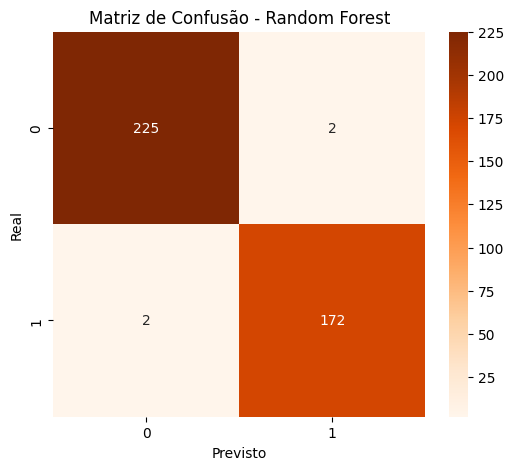

In [ ]:
mc_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(mc_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [ ]:
modelo = LogisticRegression()

In [ ]:
modelo.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred_rl = modelo.predict(X_test)

In [ ]:
acuracia_rl = accuracy_score(y_test, y_pred_rl)
print("Acurácia:", acuracia_rl)

Acurácia: 0.9775561097256857


In [ ]:
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_rl))

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       227
           1       0.95      1.00      0.97       174

    accuracy                           0.98       401
   macro avg       0.98      0.98      0.98       401
weighted avg       0.98      0.98      0.98       401



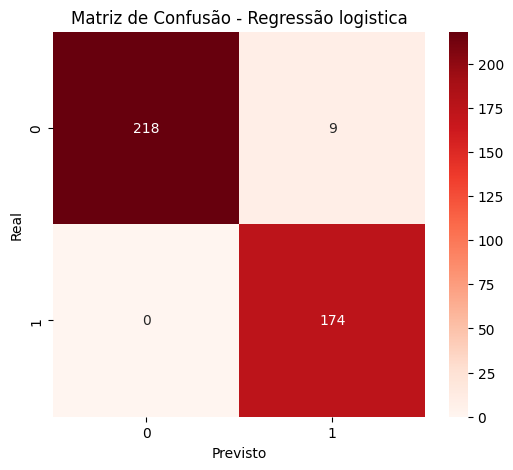

In [ ]:
mc_pl = confusion_matrix(y_test, y_pred_rl)
plt.figure(figsize=(6, 5))
sns.heatmap(mc_pl, annot=True, fmt='d', cmap='Reds')
plt.title('Matriz de Confusão - Regressão logistica')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [ ]:
print("Acúracias do modeloes:\n")

print("Acurácia do KNN:", acuracia_knn)
print("Acurácia do SVM:", acuracia_svm)
print("Acurácia do Random Forest:", acuracia_rf)
print("Acurácia da Regressão Logística:", acuracia_rl)

Acúracias do modeloes:

Acurácia do KNN: 0.9975062344139651
Acurácia do SVM: 0.9800498753117207
Acurácia do Random Forest: 0.9900249376558603
Acurácia da Regressão Logística: 0.9775561097256857


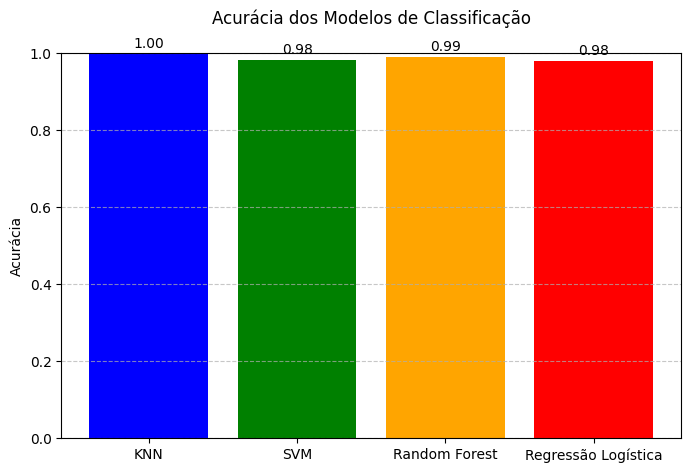

In [ ]:
modelos = ['KNN', 'SVM', 'Random Forest', 'Regressão Logística']
acuracias = [acuracia_knn, acuracia_svm, acuracia_rf, acuracia_rl]

plt.figure(figsize=(8, 5))
bars = plt.bar(modelos, acuracias, color=['Blue', 'green', 'orange', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')


plt.title('Acurácia dos Modelos de Classificação\n')
plt.ylabel('Acurácia')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Verificando o  desempenho dos algoritmos utilizando validação cruzada k-fold (k=5) para estimar a acurácia de cada modelo. A métrica utilizada é a acurácia, que representa a proporção de previsões corretas.

In [ ]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=42),
    'Regressão Logística': LogisticRegression()
}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{name}: Acurácia média = {np.mean(scores):.3f} ± {np.std(scores):.3f}')

KNN: Acurácia média = 1.000 ± 0.000
SVM: Acurácia média = 0.988 ± 0.007
Random Forest: Acurácia média = 0.994 ± 0.004
Regressão Logística: Acurácia média = 0.991 ± 0.006


Gráfico do desempenho dos algoritmos utilizando validação cruzada.

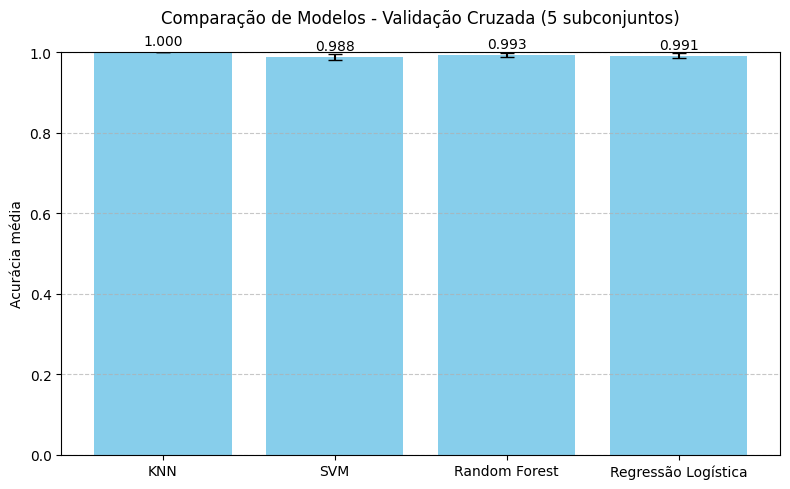

In [ ]:
mean_scores = []
std_scores = []
model_names = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    model_names.append(name)

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, mean_scores, yerr=std_scores, capsize=5, color='skyblue')
plt.ylabel('Acurácia média')
plt.title('Comparação de Modelos - Validação Cruzada (5 subconjuntos)\n')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, score in zip(bars, mean_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()